# Model Predictive Control (2) - Model-Based Prediction

## Table of contents <a class="anchor" id="toc"></a>


### [Model-Based Prediction](#modelBasedPrediction)
[Dynamic Models](#modelBasedPrediction-DM) / [Keep in mind](#keepinmind-Dynamic-models) / [Integration schemes](#integrationMethods) / [working example](#workingexample) / [Using scipy-odeint](#odeint) / [using Runge-Kutta](#RK) / [using Casadi](#Casadi) / [Checkpoint-2](#checkpoint-2)

In [1]:
from IPython.display import Image, IFrame
import ipywidgets as wg
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import time

files_root = "https://www.mazenalamir.fr/MPC/"

width=800

## This Notebook

The previous notebook entitled (MPC - General Introduction) showed that MPC control design involves three main keywords that we recall hereafter:

1. Model-Based Prediction
2. On-line Optimization 
3. Real-time

In this notebook, we shall learn a little bit more about The first weyword, namely:

**Model-Based Prediction**

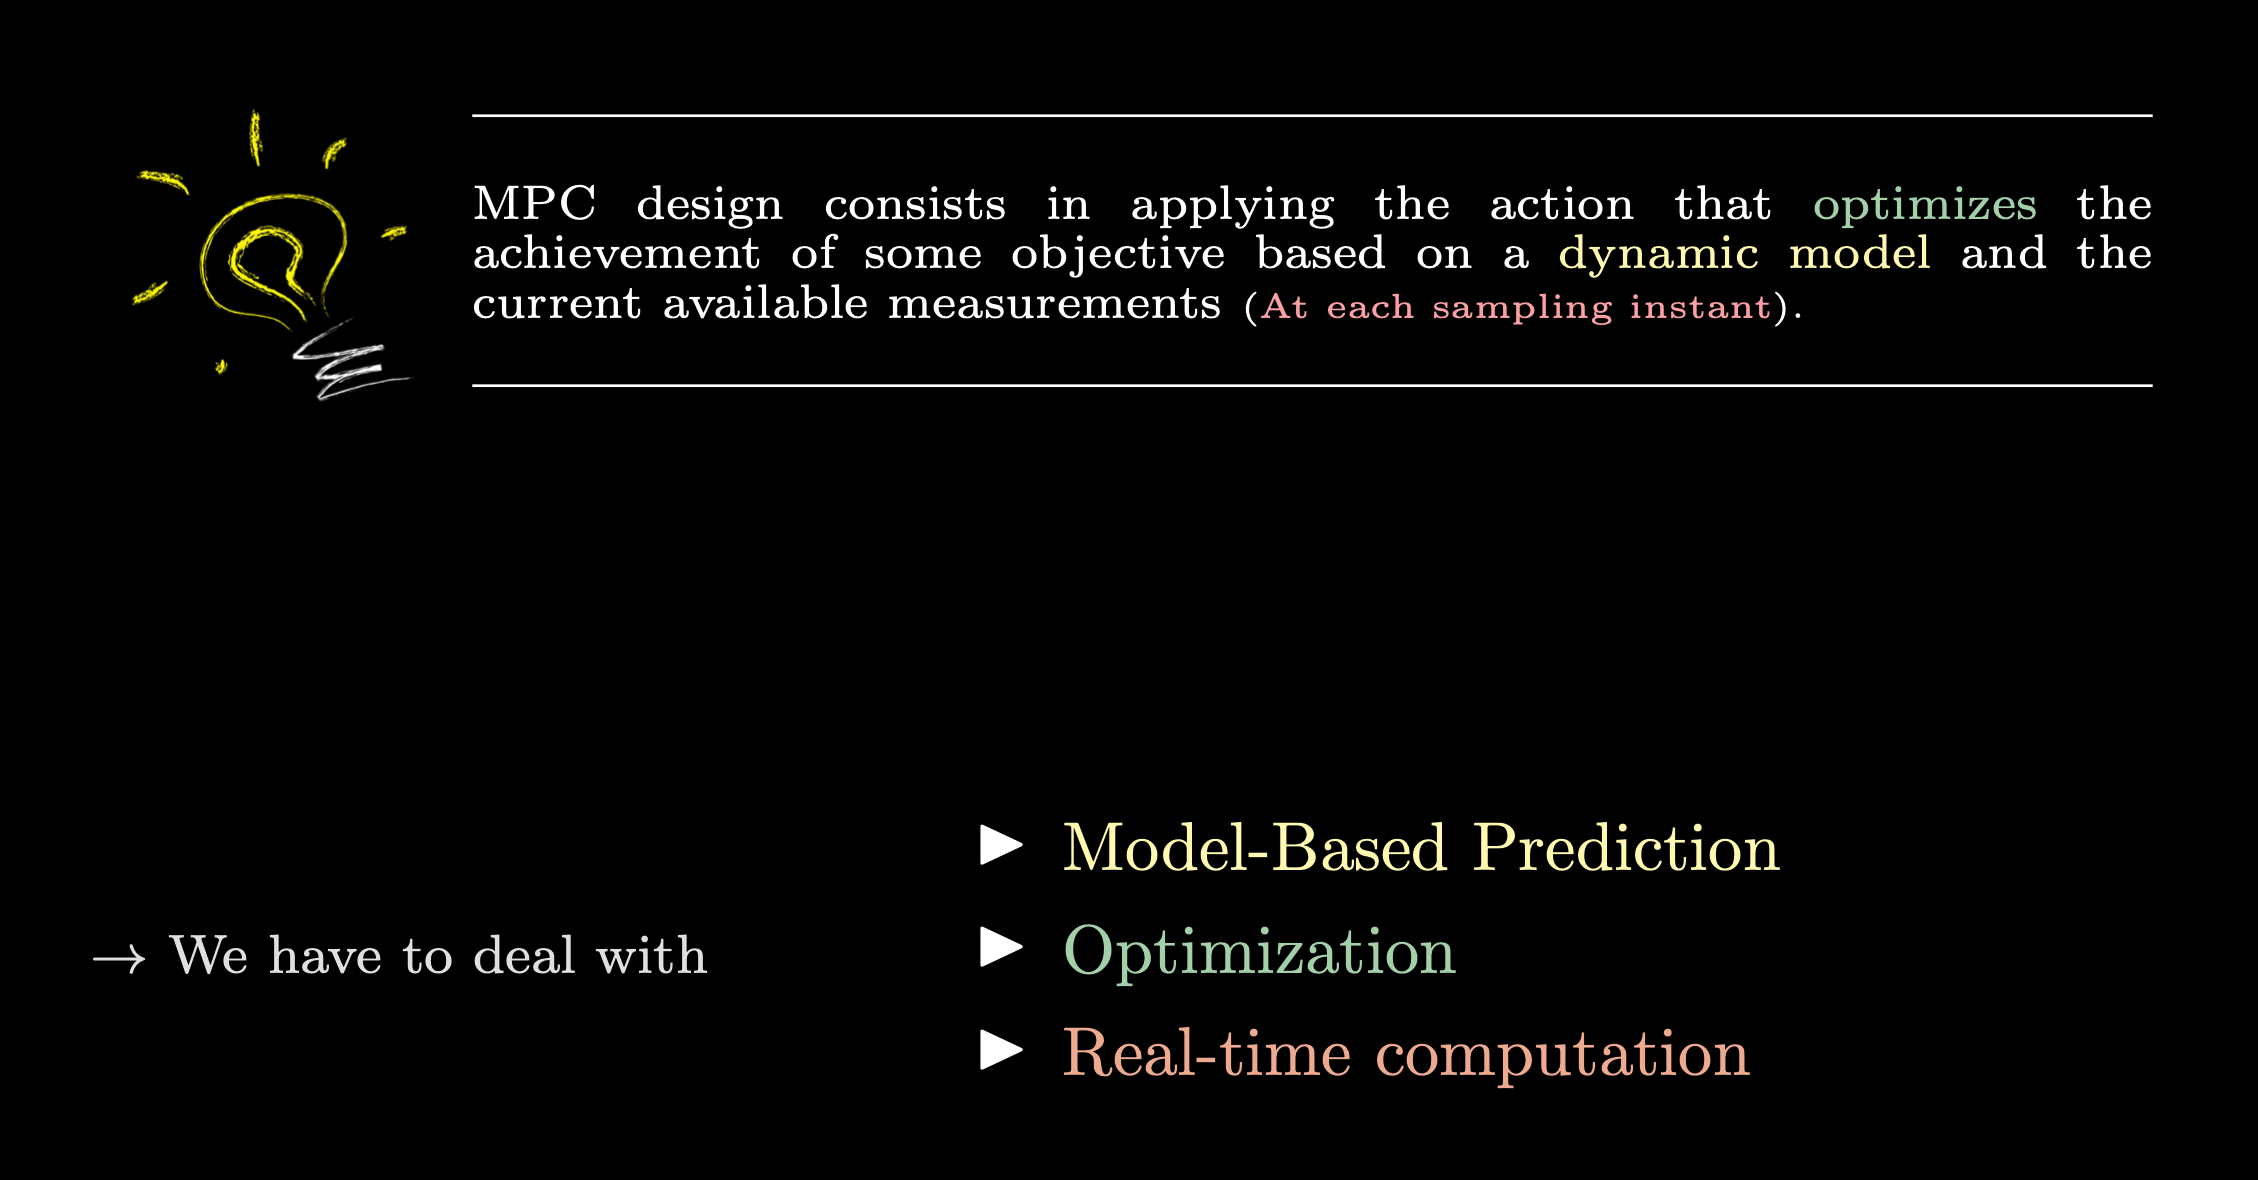

In [2]:
to_keep_in_mind = files_root+"threekeywords.png"
display(Image(to_keep_in_mind, width=width))

## Model-Based Prediction<a class="anchor" id="modelBasedPrediction"></a>

### Dynamic models<a class="anchor" id="modelBasedPrediction-DM"></a>

In [3]:
# Do not hesitate to change the width ad the hight in the IFrame Instruction below to fit your window. 
Introduction = files_root+"model_based_prediction.pdf"
display(IFrame(Introduction, width=width, height=500))

### Keep in mind<a class="anchor" id="keepinmind-Dynamic-models"></a>

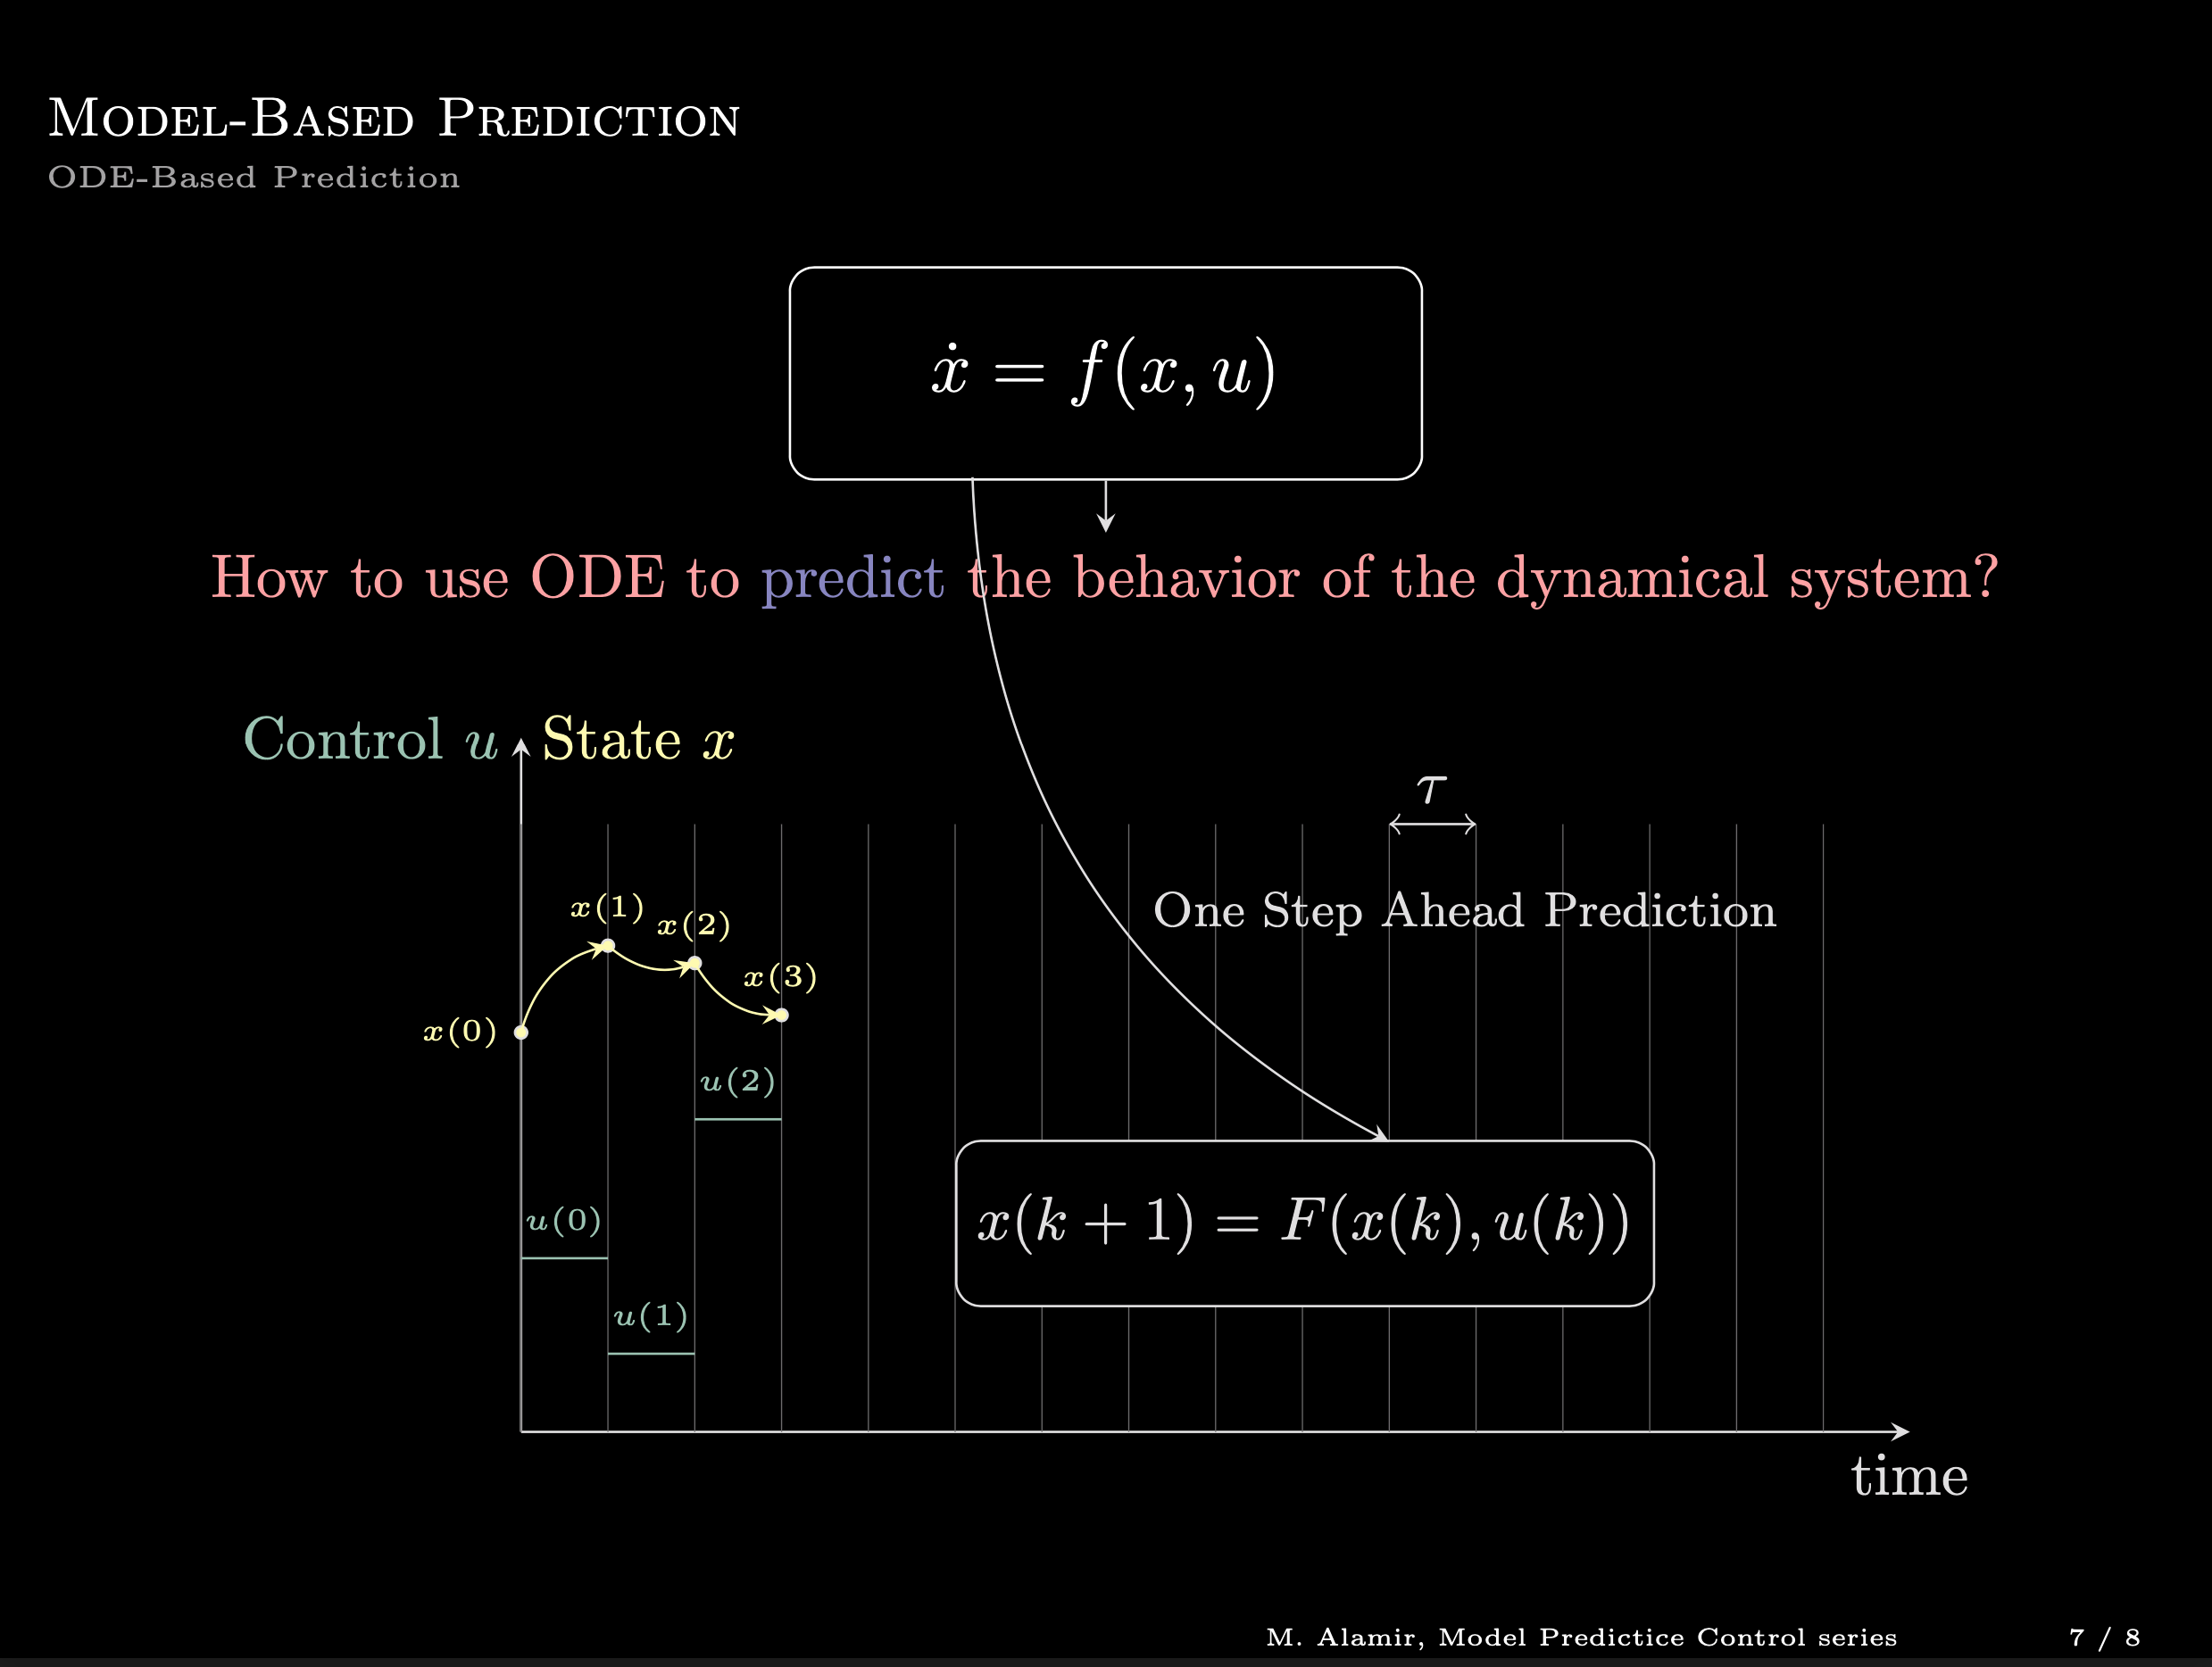

In [4]:
to_keep_in_mind = files_root+"keep_in_mind_MBP.png"
display(Image(to_keep_in_mind, width=width))

[back to toc](#toc)

### Integration schemes<a class="anchor" id="integrationMethods"></a>

In what follows, we shall examine three different ways of getting the map $x^+=F(x,u)$ given the Ordinary differential equation $\dot x=f(x,u)$, namely:

1. Using the **odeint** utility of the **scipy** python module (variable step method)
2. Using the **Runge-Kutta** fixed-step integration scheme.
3. Using the package **Casadi** (will be helpful later for MPC design) 

Obviously, there any many other options but those are largely suficient for our mission. 

### The working example<a class="anchor" id="workingexample"></a> 

In [5]:
pvtol = files_root+"pvtol.pdf"
display(IFrame(pvtol, width=width, height=500))

Let us now create the parameters vector for the forthcoming simulations:

In [6]:
#--------------- 
# defines the values 
#--------------- 
epsilon = 0.04
u0 = [0.2, 0.3]
lam = 1.0
mu = [0.1, 0.1]

p = [epsilon, u0[0], u0[1], lam, mu[0], mu[1]]

In [7]:
# the ODE describing the dynamics of the PVTOL aircraft

def pvtol_ode(x, t, p):
    
    xdot = np.zeros(6)
    epsilon, u0, lam, mu = p[0], p[1:3], p[3], p[4:6]
    #----
    u1 = u0[0]*np.exp(-lam * t) + mu[0] * x[3]
    u2 = u0[1]*np.exp(-lam * t) + mu[1] * x[4]
    #----
    xdot[0] = x[3]
    xdot[1] = x[4]
    xdot[2] = x[5]
    xdot[3] = -u1 * np.sin(x[2])+epsilon * u2 * np.cos(x[2])
    xdot[4] = u1 * np.cos(x[2])+epsilon * u2 * np.sin(x[2])
    xdot[5] = u2
    #----
    return xdot 
    

[back to toc](#toc)

### ODE integration using the scipy function odeint<a class="anchor" id="odeint"></a> 

In [8]:
#--------------- 
# Definition of the simulator
#--------------- 
def simulate_using_odeint(x0, tsim, dt, p):
    
    Nsim = int(tsim/dt)
    t = np.linspace(0,tsim,Nsim)
    X = odeint(pvtol_ode, x0, t, args=(p,))
    return t, X


In [9]:

#--------------- 
# using the simulator
#--------------- 
x0 = [0.1, -0.2, 0.4, 0, 0, 0]
tsim = 5
#----
labels = ['y', 'z', 'theta']

def plot(dt):
    
    t1 = time.time()
    t_odeint, X_odeint = simulate_using_odeint(x0, tsim, dt, p)
    cpu = str(time.time()-t1)
    for i in range(3):
        plt.plot(t_odeint, X_odeint[:,i], label=labels[i], marker='o')
    plt.grid(True)
    plt.legend()
    plt.ylim([-0.5,2])
    plt.title(f'cpu = {cpu}')
        
    return 

wg.interact(plot, dt=wg.FloatSlider(min=0.02,max=0.25,step=0.02));

interactive(children=(FloatSlider(value=0.02, description='dt', max=0.25, min=0.02, step=0.02), Output()), _do…

[back to toc](#toc)

### ODE integration using the 4th-order Runge-Kutta method<a class="anchor" id="RK"></a> 

In [10]:
display(IFrame("https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods", width=width, height=500))

In [11]:
#--------------- 
# Definition of the simulator
#--------------- 
def simulate_using_RK4(x0, tsim, dt, p):
    
    def one_step(x, t):
        
        k1 = pvtol_ode(x, t, p)
        k2 = pvtol_ode(x + 0.5 * k1 * dt, t+0.5 * dt, p)
        k3 = pvtol_ode(x + 0.5 * k2 * dt, t+0.5 * dt, p)
        k4 = pvtol_ode(x + k3 * dt, t+dt, p)
        xplus = x + dt/6.0 * (k1 + 2 * (k2 + k3) + k4)
        
        return xplus
    
    Nsim = int(tsim/dt)
    t = np.linspace(0,tsim,Nsim)
    X = [x0]
    for i in range(Nsim-1):
        X += [one_step(X[-1], t[i])]
    
    X = np.array(X)
    return t, X

In [12]:

#--------------- 
# using the simulator
#--------------- 
x0 = [0.1, -0.2, 0.4, 0, 0, 0]
tsim = 5
#----
labels = ['y', 'z', 'theta']
markers = ['o', 'x', 'square']

def plot(dt):
    
    t1 = time.time()
    t_rk4, X_rk4 = simulate_using_RK4(x0, tsim, dt, p)
    cpu = str(time.time()-t1)
    for i in range(3):
        plt.plot(t_rk4, X_rk4[:,i], label=labels[i], marker='o')
    plt.grid(True)
    plt.legend()
    plt.ylim([-0.5,2])
    plt.title(f'cpu = {cpu}')
        
    return 

wg.interact(plot, dt=wg.FloatSlider(min=0.02,max=0.25,step=0.01));

interactive(children=(FloatSlider(value=0.02, description='dt', max=0.25, min=0.02, step=0.01), Output()), _do…

Note how contrary to what is observed when using the variable step **odeint** scipy method, the result of runge kutta method depends on the sampling period. If the latter is not small enough, the results might be wrong! the samping period should be carefully chosen when using the Runge Kutta method. 

[back to toc](#toc)

### ODE integration using Casadi framework<a class="anchor" id="Casadi"></a> 

The use of [Casadi framework](https://web.casadi.org/) might seem too complicated when compared to the simple use of odeint. **The reason for which we use it is that it comes with a whole bunch of utilities that are related to control design** among them, we can cite:

1. Optimal control problem solvers 
2. Sensitivify automatic compuation (gradient, Jacobian, etc). 
3. Nonlinear equation solvers (zero finding tools)

That is the reason why it is worth investing in understanding the use of this tool for the forthcoming development included in this course. 

In [13]:
from casadi import integrator, Function, MX, vertcat

#--------------
# Define the one step Map using casadi
#--------------
def create_casadi_integrator(dt):
    
    # note that the time is considered to be the 7-th 
    # component of the state vector.
    # since the system explicitly depends on the time. 
    
    x = MX.sym('x', 7)
    xdot = MX.sym('xdot', 7)
    pc = MX.sym('p', 6)
    u = MX.sym('u', 2)

    # recall: p = [epsilon, u01, u02, lam, mu1, mu2]

    u = vertcat(pc[1]*np.exp(-pc[3] * x[6]) + pc[4] * x[3], 
                pc[2]*np.exp(-pc[3] * x[6]) + pc[5] * x[4])

    xdot = vertcat(x[3], 
                   x[4], 
                   x[5], 
                   -u[0] * np.sin(x[2])+pc[0] * u[1] * np.cos(x[2]), 
                   u[0] * np.cos(x[2])+pc[0] * u[1] * np.sin(x[2]), 
                   u[1],
                   1.0)

    # declare an ODE with state x and parameter p and derivative xdot
    ode = {'x':x, 'p':pc, 'ode':xdot}
    
    # define a one step integrator with the required dt
    integ = integrator('integrator', 'cvodes', ode, {'tf':dt})
    
    # lambda x: f(x) define a function
    one_step = lambda x, p: integ(x0=x, p=p)['xf'].full()[:,0]
    
    # Note that the .full() operation transform the casadi variable 
    # into a numpy vector. 
    return one_step # This is a function 

In [14]:
#---------------
# Define the casadi-based simulator 
#---------------

def simulate_using_casadi(x0, tsim, dt, p):
    
    # construct the one step integrator wirh dt
    one_step = create_casadi_integrator(dt)
    
    # define the extended state containing the time
    x0_casadi = np.array(list(x0)+[0])
    
    # integrate and consruct the resulting trajectories
    Nsim = int(tsim/dt)+1
    t = np.linspace(0,tsim,Nsim)
    X = [x0_casadi]
    for i in range(Nsim-1):
        X += [one_step(X[-1], p)]
    
    X = np.array(X)
    return t, X[:,0:6]


In [15]:
#--------------- 
# using the simulator
#--------------- 
x0 = [0.1, -0.2, 0.4, 0, 0, 0]
tsim = 5
#----
labels = ['y', 'z', 'theta']
markers = ['o', 'x', 'square']

def plot(dt):
    
    t1 = time.time()
    t_casadi, X_casadi = simulate_using_casadi(x0, tsim, dt, p)
    cpu = str(time.time()-t1)
    for i in range(3):
        plt.plot(t_casadi, X_casadi[:,i], label=labels[i], marker='o')
    plt.grid(True)
    plt.legend()
    plt.ylim([-0.5,2])
    plt.title(f'cpu = {cpu}')
        
    return 

wg.interact(plot, dt=wg.FloatSlider(min=0.02,max=0.25,step=0.01));

interactive(children=(FloatSlider(value=0.02, description='dt', max=0.25, min=0.02, step=0.01), Output()), _do…

Note that the results also depend on the sampling period which suggests that, when using casadi, we need to keep careful regarding the choice of the prediction horizon. As a matter of fact, this might come from the fact that we first define a one step-ahead function that we then used to generate the trajectory. Casadi might guarantee the precision for a single call (that might be very long) and not necessarily when this simple step is iterated. 

[back to toc](#toc)

## Checkpoint-2<a class="anchor" id="checkpoint-2"></a>

In this checkpoint, you are asked to write a program that enables to simulate the **crane equations** as depicted below using the following numerical values of the parameters:

$$
m=200\ \text{kg}, M=1500\ \text{kg},\ \ell=10\ \text{m}\ \text{and $g=9.81$ m/$s^2$}
$$

and using the initial state $x_0=(0,\pi/3,0,0)$ and the control $u(t)=0.1\exp(-t)$. Simulation is to be done over the time interval $[0,10]$

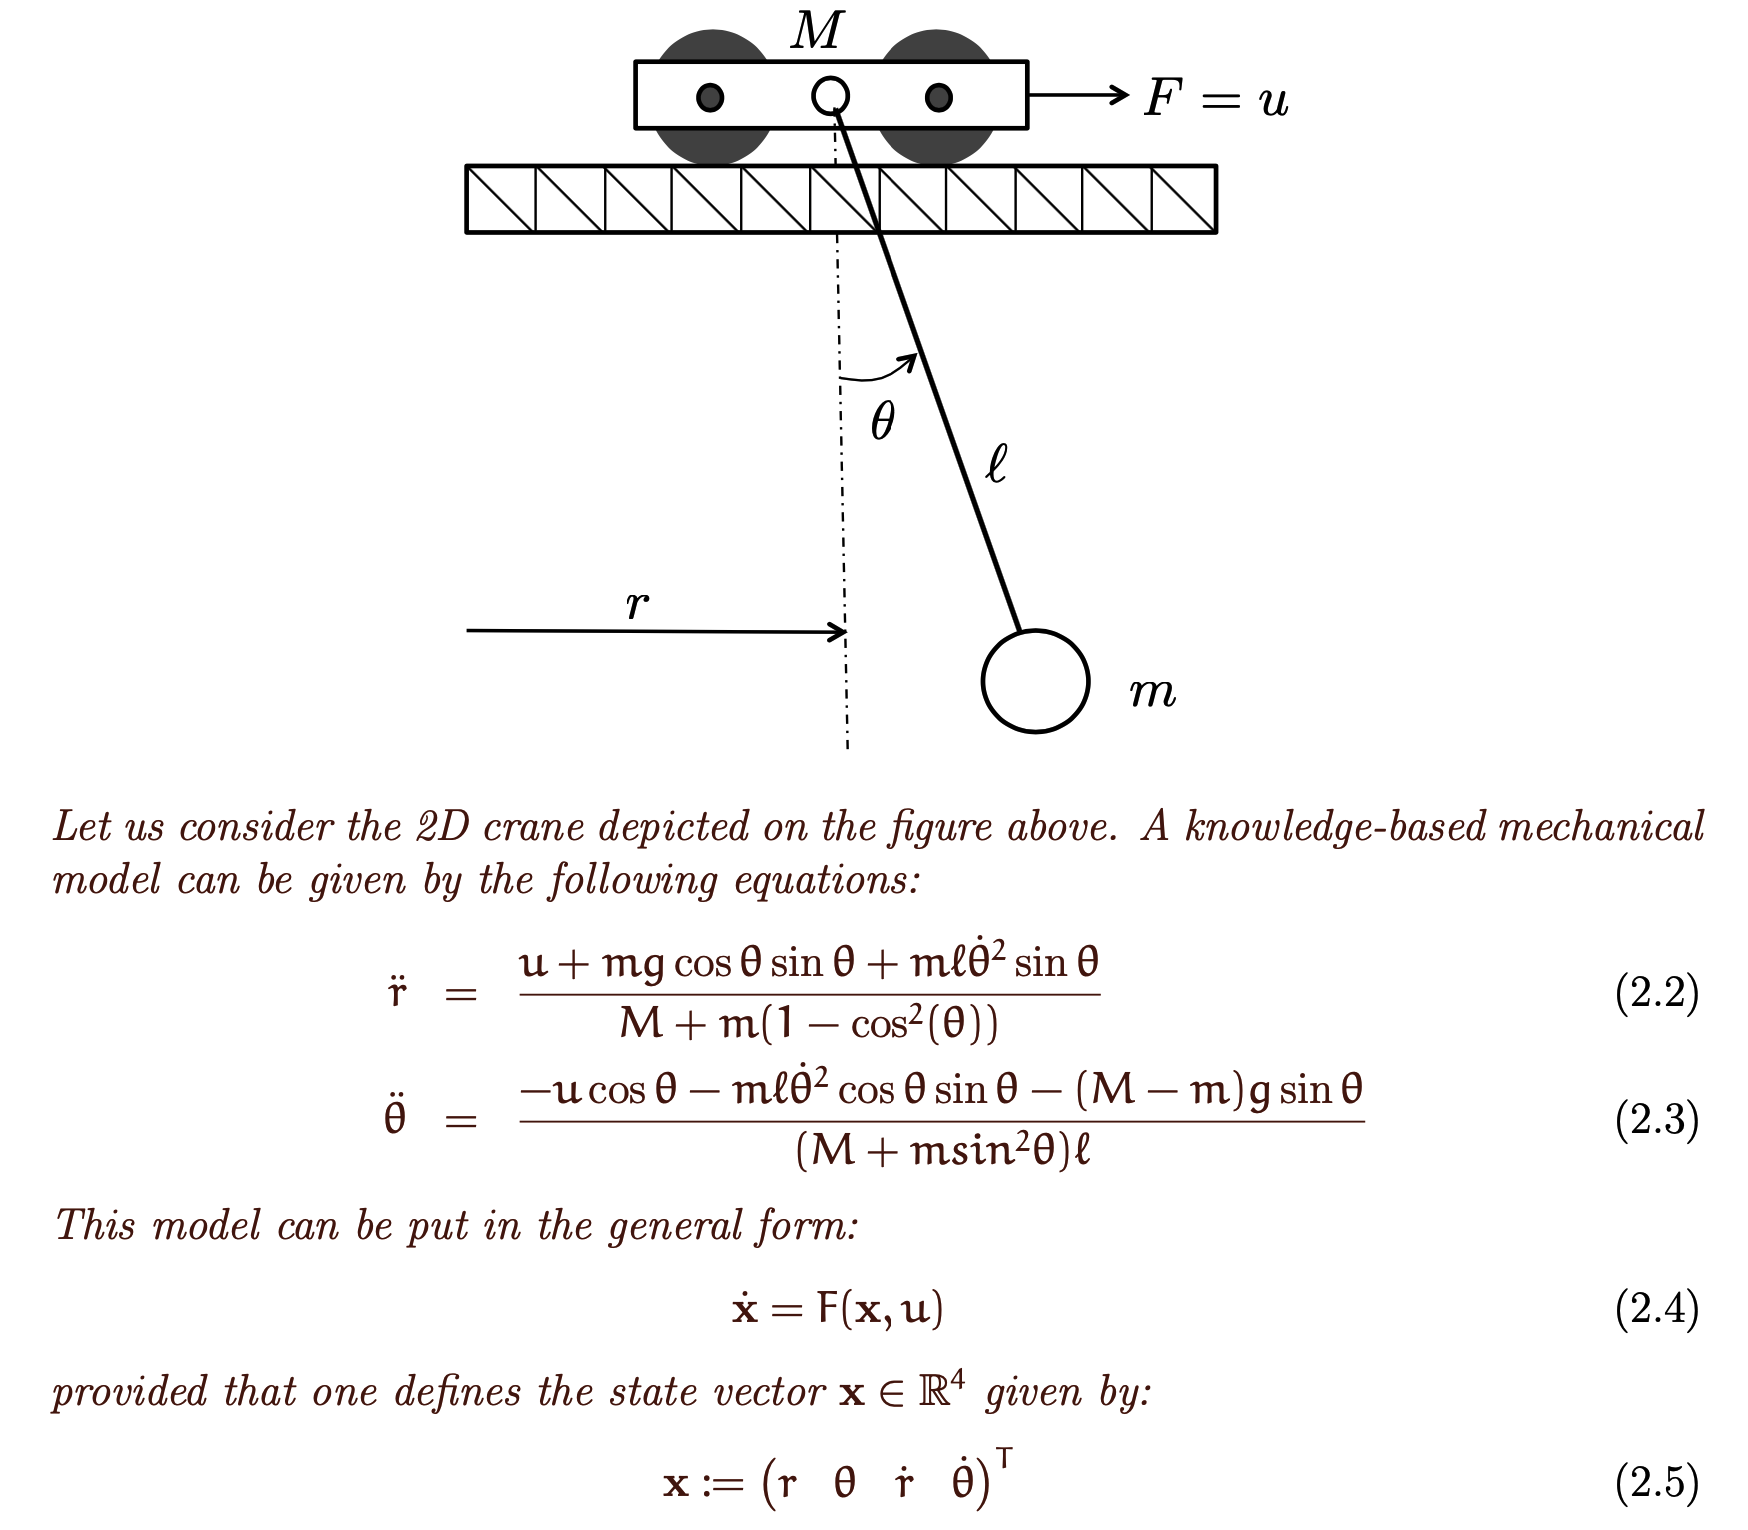

In [16]:
crane = files_root+"crane_equations.png"
display(Image(crane, width=width))

In [18]:
#%load_ext watermark
#print("----")
#%watermark -v -m -p IPython,ipywidgets,casadi,scipy,matplotlib
#print("----")
#%watermark -u -n -t -z